# Vertical 1: COVID-19 Symptoms

# Set-up + Importing Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
# Suppress seaborn warnings
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [ ]:
path = '/content/drive/My Drive/Blueprint_Datathon/Data/FeverIQ/FeverIQ_PatientData.csv'

feveriq = pd.read_csv(path)
feveriq

,Unnamed: 0,cold,flu,corona,corona_silent,corona_test_result,created_at,country
0,3161,0.0,0.1,0.1,0.0,False,2020-05-06,SI
1,3169,0.1,1.0,0.5,0.0,True,2020-05-06,CN
2,3174,2.7,4.7,3.6,1.0,True,2020-05-06,CN
3,3186,0.0,0.1,0.1,0.0,True,2020-05-06,VN
4,3243,2.0,1.0,0.5,1.0,False,2020-05-06,US
...,...,...,...,...,...,...,...,...
8198,1033149,0.2,1.1,1.5,1.0,True,2020-06-30,VN
8199,1033151,0.2,1.1,1.5,1.0,True,2020-06-30,VN
8200,1033152,0.0,1.0,1.0,0.0,False,2020-06-30,ID
8201,1033155,0.1,0.1,0.5,1.0,False,2020-06-30,EG


# Data Cleaning + EDA

In [ ]:
# rename ID
feveriq = feveriq.rename(columns={'Unnamed: 0': 'PatientID'})

In [ ]:
# Clean!!
feveriq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8203 entries, 0 to 8202
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PatientID           8203 non-null   int64  
 1   cold                8203 non-null   float64
 2   flu                 8203 non-null   float64
 3   corona              8203 non-null   float64
 4   corona_silent       8203 non-null   float64
 5   corona_test_result  8203 non-null   bool   
 6   created_at          8203 non-null   object 
 7   country             8203 non-null   object 
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 456.7+ KB


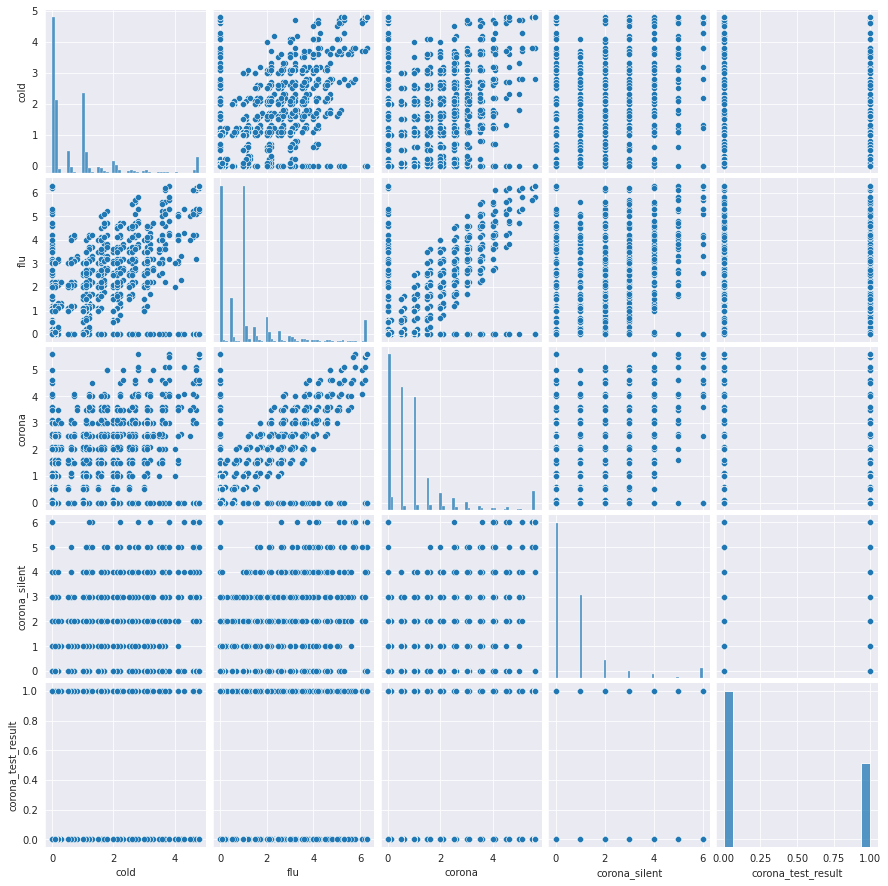

In [ ]:
# Invetigate distributions and relationships
sns.pairplot(feveriq.drop(['PatientID'], axis=1));

Between cold, flu, and corona, we notice a generally positive linear correlation (i.e. these sypmtoms are associated with each other)

We notice that corona_silent values are discrete on the range [0, 6], so we will treat that variable as categorical and one-hot encode those values, instead of treating it as continuous. We also notice that there is a larger proportion of negative test results, so we need to keep that in mind when we build the model (ensure proportion is maintained)

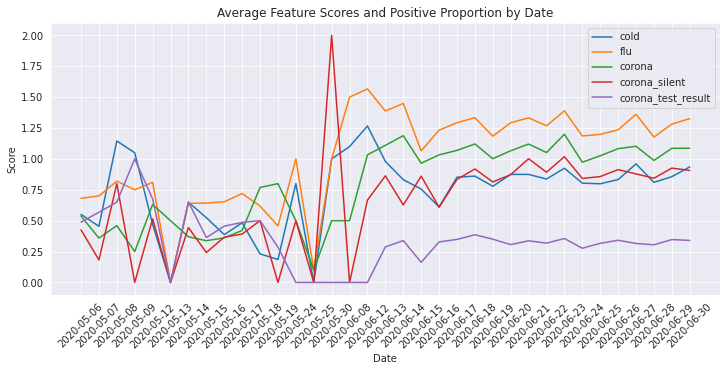

In [ ]:
# Create Time Series Data grouped by Date
per_date = feveriq.groupby('created_at').mean()
per_date = per_date.drop(['PatientID'], axis=1)
per_date = per_date.reset_index()

# Visualize Time Series Data
plt.figure(figsize=(12, 5))
plt.plot(per_date['created_at'], per_date['cold'], label='cold');
plt.plot(per_date['created_at'], per_date['flu'], label='flu');
plt.plot(per_date['created_at'], per_date['corona'], label='corona');
plt.plot(per_date['created_at'], per_date['corona_silent'], label='corona_silent');
plt.plot(per_date['created_at'], per_date['corona_test_result'], label='corona_test_result');
plt.xticks(rotation=45);
plt.legend();
plt.xlabel('Date');
plt.ylabel('Score')
plt.title('Average Feature Scores and Positive Proportion by Date');

# Feature Engineering

In [ ]:
# One hot encodes corona_silent, extracts month and day of week, 
# one-hot encodes country
def clean(df):
  # corona_test_results are binary
  df['corona_test_result'] = df['corona_test_result'].astype(int)

  # corona_silent values are discreteized, so will one-hot encode
  df['corona_silent'] = df['corona_silent'].astype(str)
  corona_silent_dummies = pd.get_dummies(df[['PatientID', 'corona_silent']])
  df = df.merge(corona_silent_dummies, on='PatientID')
  df['corona_silent'] = df['corona_silent'].astype(float)
  df = df.drop(['corona_silent'], axis=1)

  # Add month and day of week column, drop date
  df['created_at'] = pd.to_datetime(df['created_at'])
  df['month'] = df['created_at'].dt.month
  df['day_of_week'] = df['created_at'].dt.dayofweek
  ### Drop created_at for now
  df = df.drop(['created_at'], axis=1)

  # One hot encode Country, Month, Day of Week
  df['month'] = df['month'].astype(str)
  df['day_of_week'] = df['day_of_week'].astype(str)
  return pd.get_dummies(df)

df = clean(feveriq)

### Preprocessing

In [ ]:
# Returns X and Y (df from clean() above)
def pre_process(df):
  X = df.drop(['corona_test_result', 'PatientID'], axis=1)
  Y = df['corona_test_result']
  return X, Y

In [ ]:
# Gets baseline models (all symptoms only) from clean()
def baseline(X):
  X = X.iloc[:, :10]
  return X

In [ ]:
# returns model with symptoms and interactions between them
def interaction_X(X):
  #X = X.iloc[:, :10]
  num_cols = len(X.columns.values)

  for i in np.arange(num_cols-1):
    j = i + 1
    while j < num_cols:
      col1 = X.columns.values[i]
      col2 = X.columns.values[j]
      if ('corona_silent' not in col1) | ('corona_silent' not in col2):
        newcol = col1+col2
        X[newcol] = X[col1] + X[col2]
      j += 1
  
  return X


# Simple Logistic Regression

In [ ]:
# Cross Validated Logistic Regression
def simple_log_reg(X, Y):
  seed = 0
  test_size = 0.2
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
  clf = LogisticRegressionCV(cv=10, random_state=0).fit(X_train, Y_train)

  # Compute Metrics
  fpr, tpr, thresholds = metrics.roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
  auc1 = np.round(auc(fpr, tpr), 2)
  auc2 = np.round(roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1]), 2)
  train_acc = np.round(clf.score(X_train, Y_train), 2)
  test_acc = np.round(clf.score(X_test, Y_test), 2)
  cm = confusion_matrix(Y_test, clf.predict(X_test))
  tn, fp, fn, tp = cm.ravel()
  precision = np.round(tp / (tp + fp), 2)
  recall = np.round(tp / (tp + fn), 2)

  print('AUC = ' + str(auc1))
  print('AUC_ROC = ' + str(auc2))
  print('Train accuracy = ' + str(train_acc))
  print('Test accuracy = ' + str(test_acc))

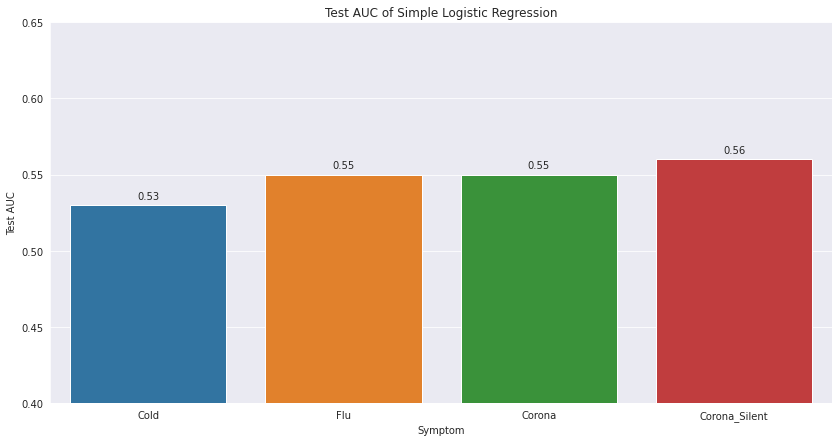

In [ ]:
# Plot results of simple models (generated by function above)
models = ['Cold', 'Flu', 'Corona', 'Corona_Silent']
aucs = [0.53, 0.55, 0.55, 0.56]

auc_df = pd.DataFrame(data={'Model': models, 'Test AUC': aucs})
auc_df

# Simple Feature Logistic Regression
plt.figure(figsize=(14, 7))
g = sns.barplot(x="Model", y="Test AUC", data=auc_df);
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0.4, 0.65)
plt.xlabel('Symptom')
plt.title('Test AUC of Simple Logistic Regression');

# More Exhaustive Logistic Regression

Goal: Build a binary classifier that can predict "corona_test_result"

In [ ]:
# Cross Validated Logistic Regression
def logistic_regression(X, Y):
  seed = 0
  test_size = 0.2
  X_train, X_test, Y_train, Y_test = train_test_split(X_simp, Y, test_size=test_size, random_state=seed)
  clf = LogisticRegressionCV(cv=10, random_state=0).fit(X_train, Y_train)

  # Compute Metrics
  fpr, tpr, thresholds = metrics.roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
  auc1 = np.round(auc(fpr, tpr), 2)
  auc2 = np.round(roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1]), 2)
  train_acc = np.round(clf.score(X_train, Y_train), 2)
  test_acc = np.round(clf.score(X_test, Y_test), 2)
  cm = confusion_matrix(Y_test, clf.predict(X_test))
  tn, fp, fn, tp = cm.ravel()
  precision = np.round(tp / (tp + fp), 2)
  recall = np.round(tp / (tp + fn), 2)

  print('AUC = ' + str(auc1))
  print('AUC_ROC = ' + str(auc2))
  print('Train accuracy = ' + str(train_acc))
  print('Test accuracy = ' + str(test_acc))

  # Plot ROC Curve
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
  ax1.plot(fpr,tpr,label="AUC="+str(auc1))
  ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8);
  ax1.legend();
  ax1.set_xlabel('FPR')
  ax1.set_ylabel('TPR')
  ax1.set_title('ROC Curve for Logistic Regression Classifier');
  txt = 'Precision = ' + str(precision) + ', Recall = ' + str(recall)
  ax1.text(0.5, -0.2, txt, ha='center')

  # Plot Confusion Matrix
  sns.heatmap(pd.DataFrame(cm), annot=True, cmap="GnBu", ax=ax2);
  ax2.set_ylabel('True Label');
  ax2.set_xlabel('Predicted Label');
  ax2.set_title('Confusion Matrix for Logistic Regression Classifier');
  txt = 'Test Accuracy = ' + str(test_acc)
  ax2.text(1, 2.3, txt, ha='center');

AUC = 0.56
AUC_ROC = 0.56
Train accuracy = 0.67
Test accuracy = 0.68


# Support Vector Classifier

In [ ]:
# Create Universal Split
seed = 0
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
# runs SVC given in X_train and Y_train
def sv_classifier(X_train, Y_train):
  # 10-fold cross-validation for SVC
seed = 0
svc = svm.SVC(kernel='rbf', probability=True)
svc.fit(X_train, Y_train)

# Compute AUC
probas_ = svc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

[0.64428499 0.65532961 0.61940922 0.59704609 0.6402852  0.64820474
 0.64869366 0.60424752 0.64872931 0.59549274]
0.6301723084218014


# K Nearest Neighbor

In [ ]:
# run KNN given X and Y
def find_best_k(X, Y):
  # Check Cross Vals
  seed = 0
  test_size = 0.2
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

  # 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
  knn = KNeighborsClassifier(n_neighbors=5)
  scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='roc_auc')
  print(scores)
  print(scores.mean())

  # search for an optimal value of K for KNN
  k_range = list(range(45, 81))
  k_scores = []
  best_k = 0
  best_score = 0
  for k in k_range:
      knn = KNeighborsClassifier(n_neighbors=k)
      scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='roc_auc')
      k_scores.append(scores.mean())
      if scores.mean() > best_score:
        best_score = scores.mean()
        best_k = k
  print(k_scores)

  # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
  plt.plot(k_range, k_scores)
  plt.xlabel('Value of K for KNN')
  plt.ylabel('Cross-Validated AUC')

  return best_k

[0.62697769 0.58727181 0.57176471 0.59065444 0.57712758 0.61334861
 0.54080978 0.60626942 0.60686529 0.5918411 ]
0.591293041981683


In [ ]:
# 10-fold cross-validation with K=best_k for KNN (the n_neighbors parameter)
def run_knn(X_train, Y_train):
  seed = 0
  knn = KNeighborsClassifier(n_neighbors=59)
  scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='roc_auc')
  print(scores)
  print(scores.mean())

  knn.fit(X_train, Y_train)
  test_auc = knn.score(X_test, Y_test)
  print(test_auc)

[0.65735801 0.65574037 0.61283932 0.63888974 0.67179017 0.66594347
 0.64995162 0.60601477 0.64920295 0.61362872]
0.6421359136130942
0.6946983546617916


In [ ]:
# Build Bagged Logistic Regression Model
# takes in dataframe, # models, # folds, cv, probability threshold
### random_state for LogisticRegressionCV NOT random seed for the sampling

def Bootstrap_LogisticRegression(X_train, Y_train, X_test, Y_test, n_models, cv, threshold, random_state):
  # Recontstruct datframe
  df = X_train.copy()
  df['Y'] = Y_train
  # empty array for prediction probabilities
  predicted_probs = np.zeros(len(X_test))
  for i in np.arange(n_models):
    # get bootstrapped sample
    boot_sample = df.sample(n=len(df), replace=True)
    Y = df['Y']
    X = df.drop(['Y'], axis=1)
    # build model from bootstrap, predict and store probs
    model = LogisticRegressionCV(cv=cv, random_state=random_state).fit(X, Y)
    predictions = np.array(model.predict_proba(X_test)[:,1])
    predicted_probs = predicted_probs + predictions
  
  # average across all samples
  predicted_probs = predicted_probs / n_models

  # compute predictions and accuracy
  predictions = [1 if x >= threshold else 0 for x in predicted_probs]
  accuracy = sum(predictions == Y_test) / len(Y_test)

  # Compute Metrics
  fpr, tpr, thresholds = metrics.roc_curve(Y_test, predicted_probs)
  auc1 = np.round(auc(fpr, tpr), 2)
  print('AUC1 = ' + str(auc1))
  auc2 = np.round(roc_auc_score(Y_test, predicted_probs), 2)
  print('AUC2 = ' + str(auc2))
  train_acc = np.round(clf.score(X_train, Y_train), 2)
  test_acc = np.round(clf.score(X_test, Y_test), 2)
  print('Test acc = ' + str(train_acc))
  print('Train acc = ' + str(test_acc))
  cm = confusion_matrix(Y_test, clf.predict(X_test))
  tn, fp, fn, tp = cm.ravel()
  precision = np.round(tp / (tp + fp), 2)
  recall = np.round(tp / (tp + fn), 2)

  print('AUC = ' + str(auc1))
  print('AUC_ROC = ' + str(auc2))
  print('Train accuracy = ' + str(train_acc))
  print('Test accuracy = ' + str(test_acc))

  # Plot ROC Curve
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
  ax1.plot(fpr,tpr,label="AUC="+str(auc1))
  ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8);
  ax1.legend();
  ax1.set_xlabel('FPR')
  ax1.set_ylabel('TPR')
  ax1.set_title('ROC Curve for Logistic Regression Classifier');
  txt = 'Precision = ' + str(precision) + ', Recall = ' + str(recall)
  ax1.text(0.5, -0.2, txt, ha='center')

  # Plot Confusion Matrix
  sns.heatmap(pd.DataFrame(cm), annot=True, cmap="GnBu", ax=ax2);
  ax2.set_ylabel('True Label');
  ax2.set_xlabel('Predicted Label');
  ax2.set_title('Confusion Matrix for Logistic Regression Classifier');
  txt = 'Test Accuracy = ' + str(test_acc)
  ax2.text(1, 2.3, txt, ha='center');

In [ ]:
# Bagged Cross Validated Logistic Regression
seed = 0
cv = 10
## Hyperparameters
n_models = 25
threshold = 0.5

Bootstrap_LogisticRegression(X_train, Y_train, X_test, Y_test, n_models, cv, threshold, random_state=seed)

KeyboardInterrupt: ignored

# XgBoost

In [ ]:
def calculate_scores(tn,fp, fn, tp):
    sens = tp / (tp+fn)
    spec = tn / (tn+fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    lr_pos = sens / (1-spec)
    lr_neg =  (1-sens)/ spec
    dor = (lr_pos)/(lr_neg)
    return sens, spec, ppv, npv, lr_pos, lr_neg, dor
#test case
calculate_scores(0.2, 0.7, 0.8, 0.2)
## split data into train and test sets
seed = 42
test_size = 0.2
def run_algo(X, Y, depth, lamb, pos_weight):
    # @param, X: training matrix
    # @param, Y: label vector
    # @param, depth: max_depth of each tree
    # @param, lamb: bias hyperparameter
    # @param, pos_weight: used to balance classes
    input_X = X
    X = np.matrix(X)[:,1:]
    Y = np.array([int(np.floor(i)) for i in Y])
    print('Starting 5-fold cross-validation...')
    senses, specs, ppvs, npvs, lr_poses, lr_negs, dors, aucs, auprcs = ([] for i in range(9)) 
    kf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model = XGBClassifier(max_depth=depth, reg_lambda=lamb, reg_alpha=0, scale_pos_weight=pos_weight, seed=3)
        model.fit(X_train, Y_train, eval_metric='logloss', early_stopping_rounds = 5, eval_set=[(X_test, Y_test)])
        preds = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(Y_test, preds).ravel()
        scores = calculate_scores(tn, fp, fn, tp)
        model_features = model.feature_importances_
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
        auc = roc_auc_score(Y_test, model.predict(X_test))
        auprc = average_precision_score(Y_test, model.predict(X_test))
        senses.append(scores[0])
        specs.append(scores[1])
        ppvs.append(scores[2])
        npvs.append(scores[3])
        lr_poses.append(scores[4])
        lr_negs.append(scores[5])
        dors.append(scores[6])
        aucs.append(auc)
        auprcs.append(auprc)    
    print('Predictions done.')
    #reporting these scores for the last fold of cross-validation only
    print('Number of true positives: ', tp)
    print('Number of false positives: ', fp)
    print('Number of true negatives: ', tn)
    print('Number of false negatives: ', fn)
    #print('confusion matrix', [PPV,NPV,tn,fp,fn,tp])
    print('params', depth,lamb, pos_weight)
    #reporting average across all folds for these
    print('sens', np.mean(senses))
    print('spec', np.mean(specs))
    print('ppv', np.mean(ppvs))
    print('npv', np.mean(npvs))
    print('auroc', np.mean(aucs))
    print('auroc std dev', np.std(aucs))
    print('LR+', np.mean(lr_poses))
    print('LR-', np.mean(lr_negs))
    print('DOR', np.mean(dors))
    print('auprc', np.mean(auprcs))
    print('total number of positive encounters', sum(Y_train)+sum(Y_test))
    print('total number of negative encounters', len(Y_train) + len(Y_test))
    #refitting with original matrix to preserve feature labels
    X_train, X_test, Y_train, Y_test = train_test_split(input_X, Y, test_size=test_size, random_state=seed)
    model = XGBClassifier(max_depth=depth, reg_lambda=lamb, reg_alpha=0, scale_pos_weight=pos_weight, seed=3)
    model.fit(X_train, Y_train, eval_metric='logloss',
              early_stopping_rounds = 5, eval_set=[(X_test, Y_test)], verbose = False)
    model_features = model.feature_importances_
    #print('Feature Importances', model_features)
    ax = plot_importance(model, importance_type = 'weight', max_num_features = 20)
    #ax.figure.savefig('models/best_model/fp_fig_' + model_name)
    display(ax)
    return fpr, tpr, np.mean(aucs), model, [np.mean(ppvs),np.mean(npvs),tn,fp,fn,tp]

Starting 5-fold cross-validation...
[0]	validation_0-logloss:0.690169
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.687098
[2]	validation_0-logloss:0.68511
[3]	validation_0-logloss:0.68263
[4]	validation_0-logloss:0.681137
[5]	validation_0-logloss:0.679679
[6]	validation_0-logloss:0.678047
[7]	validation_0-logloss:0.676825
[8]	validation_0-logloss:0.675534
[9]	validation_0-logloss:0.674443
[10]	validation_0-logloss:0.673668
[11]	validation_0-logloss:0.672774
[12]	validation_0-logloss:0.671943
[13]	validation_0-logloss:0.671639
[14]	validation_0-logloss:0.670784
[15]	validation_0-logloss:0.670253
[16]	validation_0-logloss:0.669934
[17]	validation_0-logloss:0.669492
[18]	validation_0-logloss:0.669199
[19]	validation_0-logloss:0.669042
[20]	validation_0-logloss:0.668637
[21]	validation_0-logloss:0.66843
[22]	validation_0-logloss:0.667977
[23]	validation_0-logloss:0.667594
[24]	validation_0-logloss:0.667262
[25]	validation_0-logloss:0.667051


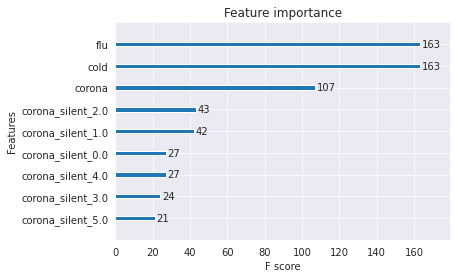

In [ ]:
fpr, tpr, auc, model, confusion = run_algo(X.astype('float64'), Y, 4, 100, 2)

In [ ]:
#Double Checking Model Results
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
auc = roc_auc_score(Y_test, model.predict(X_test))
auc

0.5998222778224565

In [ ]:
# Final Model Results
design_matrix_types = ['Initial Symptoms'] * 5 + ['Symptoms and Interactions'] * 5 + ['Symptoms, Time, and Country'] * 5
models = ['KNN', 'Logistic Regression', 'SVC', 'XG Boost', 'Bagged Logistic Regression'] * 3
# Results taken from sequential runs of the code above
aucs = [0.69, 0.56, 0.59, 0.60, 0.56, 0.70, 0.56, 0.59, 0.60, 0.66, 0.72, 0.75, 0.59, 0.70, 0.71]

auc_df = pd.DataFrame(data={'Feature Types':design_matrix_types, 'Model': models, 'Test AUC': aucs})
auc_df

,Feature Types,Model,Test AUC
0,Initial Symptoms,KNN,0.69
1,Initial Symptoms,Logistic Regression,0.56
2,Initial Symptoms,SVC,0.59
3,Initial Symptoms,XG Boost,0.60
4,Initial Symptoms,Bagged Logistic Regression,0.56
5,Symptoms and Interactions,KNN,0.70
6,Symptoms and Interactions,Logistic Regression,0.56
7,Symptoms and Interactions,SVC,0.59
8,Symptoms and Interactions,XG Boost,0.60
9,Symptoms and Interactions,Bagged Logistic Regression,0.66


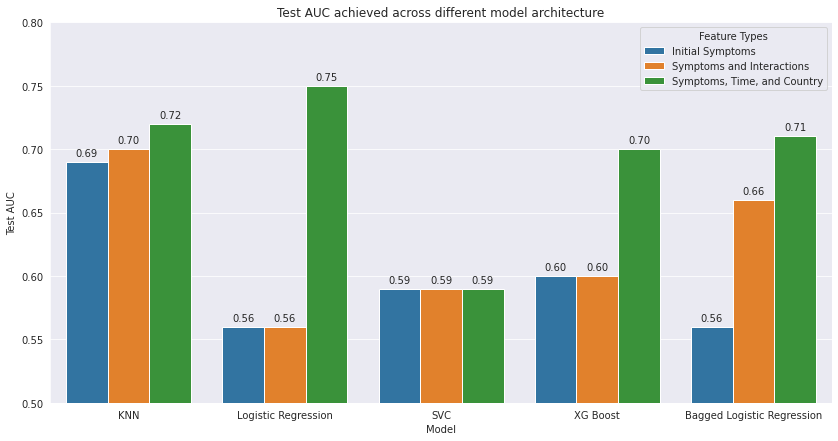

In [ ]:
# Plot Final Model Results
plt.figure(figsize=(14, 7))
g = sns.barplot(x="Model", y="Test AUC", hue='Feature Types', data=auc_df);
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0.5, 0.8)
plt.title('Test AUC achieved across different model architecture');